# 🗂️ Step 1: Load and check missing Data

In [1]:
import numpy as np, pandas as pd
df = pd.read_json('problems_data.jsonl', lines=True)
df.isnull().sum()

title                 0
description           0
input_description     0
output_description    0
sample_io             0
problem_class         0
problem_score         0
url                   0
dtype: int64

Clearly, our data doesn't contain any missing values.

# 🛠️ Step 2: Combine important text fields into one single text feature

In [2]:
df['combined_text'] = df['description'] + " " + df['input_description'] + " " + df['output_description']

# Drop useless columns which can add noise
df.drop(['title', 'description', 'sample_io', 'url'], axis=1, inplace=True)

# Encoding classes in increasing order of difficulty:
df['problem_class'] = df['problem_class'].map({
    'easy': 0,
    'medium': 1,
    'hard': 2
})
df.head()

,input_description,output_description,problem_class,problem_score,combined_text
0,The input consists of one line with two intege...,The output consists of $M$ lines where the $i$...,2,9.7,Unununium (Uuu) was the name of the chemical\n...
1,"The input consists of $10$ test cases, which a...",Print $K$ lines with\n the positions of the...,2,9.7,A number of eccentrics from central New York h...
2,,,2,9.6,Mario and Luigi are playing a game where they ...
3,The first line contains two integers $L$ and $...,The output consists of a single line consistin...,2,9.6,Žofka is bending a copper wire. She starts wit...
4,The first line of input consists of two intege...,Write a single line containing the length need...,2,9.6,"Your dog Spot is let loose in the park. Well, ..."


In [3]:
df.problem_class.value_counts()

problem_class
2    1941
1    1405
0     766
Name: count, dtype: int64

#### Clearly "hard" class is in majority and "easy" in minority, so we'll take of this class imbalance while training.

# 🔧 Step 3: Feature Engineering

### 1. Count math symbols:

In [4]:
import re
MATH_SYMBOL_PATTERN = r"[+\-*/%^=<>≤≥≠]"

def count_math_symbols(text):
    if not isinstance(text, str):
        return 0
    return len(re.findall(MATH_SYMBOL_PATTERN, text))
df["math_symbol_count"] = df["input_description"].apply(count_math_symbols)

### 2. Clean "combined_text":

In [5]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

# Load small English spaCy model for tokenization + lemmatization
nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
    # Handle missing/non-string inputs safely
    if not isinstance(text, str):
        return ""

    # Normalize different types of unicode quotes to standard ASCII
    text = text.replace("’", "'").replace("‘", "'")
    text = text.replace("“", '"').replace("”", '"')

    # Remove LaTeX-style math expressions (e.g., $N = 100$)
    text = re.sub(r"\$[^$]*\$", " ", text)
    
    # Remove variable subscripts like u_i, x_1
    text = re.sub(r"_\w+", "", text)

    # Remove leftover mathematical / comparison symbols
    text = re.sub(r"[<>^_=]", " ", text)

    # Remove colon-based tokens (e.g., :input, :output)
    text = re.sub(r":\w+", " ", text)
    
    # Replace escaped newlines and tabs with spaces
    text = text.replace("\\n", " ").replace("\\t", " ")

   # Remove punctuation and special characters (keep only words & spaces)
    text = re.sub(r"[^\w\s]", " ", text)

    # Collapse multiple spaces into a single space
    text = re.sub(r"\s+", " ", text)

     # Convert to lowercase and strip leading/trailing spaces
    text = text.lower().strip()

    # Apply spaCy NLP pipeline
    doc = nlp(text)
    tokens = []

    for token in doc:
        # Skip stopwords (e.g., 'the', 'is') and punctuation
        if token.is_stop or token.is_punct:
            continue

        # Use lemma to reduce words to their base form
        tokens.append(token.lemma_)

    # Return cleaned, lemmatized text
    return " ".join(tokens)

# Apply preprocessing to combined problem text
df['clean_text'] = df['combined_text'].apply(preprocess_text)

#### Define weights (as per difficulty) of important keywords of programming problems:

In [6]:
keyword_weights = {
    "dp": 2.5,
    "graph": 2.0,
    "greedy": 1.8,
    "math": 1.5,
    "geometry": 1.8,
    "string": 1.2,
    "shortest path": 3.0,
    "flow": 3.0,
    "matching": 3.0,
    "number theory": 2.5,
    "binary search": 2.0,
    "recursion": 1.5,
    "tree": 1.5,
    "dfs": 1.5,
    "bfs": 1.5,
    "combinatoric": 2.0,
    "modulo": 1.3,
    "xor": 1.3,
    "query": 1.2
}

### 3. Adding text length and keywords as features:

In [7]:
df["text_len"] = df["clean_text"].str.split().apply(len)
def add_keywords_and_strip_text(df, text_col="clean_text"):
    text = df[text_col].str.lower()

    # build one combined regex for all keywords (longer first!)
    sorted_keywords = sorted(keyword_weights.keys(), key=len, reverse=True)
    combined_pattern = r"\b(" + "|".join(map(re.escape, sorted_keywords)) + r")\b"

    for kw, weight in keyword_weights.items():
        pattern = r"\b" + re.escape(kw) + r"\b"
        counts = text.str.count(pattern)
        df[f"{kw}"] = counts * weight

    # REMOVE keywords from clean_text
    df[text_col] = ( text.str.replace(combined_pattern, " ", regex=True).str.replace(r"\s+", " ", regex=True).str.strip())
    return df

df = add_keywords_and_strip_text(df)

# ➕ Step 4: Concatenation of engineered features with datset

In [8]:
keywords = list(keyword_weights.keys())
X = pd.concat([df[keywords], df[['clean_text', 'math_symbol_count', 'text_len']]], axis=1)
X.columns

Index(['dp', 'graph', 'greedy', 'math', 'geometry', 'string', 'shortest path',
       'flow', 'matching', 'number theory', 'binary search', 'recursion',
       'tree', 'dfs', 'bfs', 'combinatoric', 'modulo', 'xor', 'query',
       'clean_text', 'math_symbol_count', 'text_len'],
      dtype='object')

In [9]:
# Separation of targets for classification and regression:
y_class = df['problem_class']
y_score = df['problem_score']

# 🔢 Step 5: Train Test Split and handling class imbalance

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

X_train, X_test, y_train_class, y_test_class = train_test_split(X, y_class, test_size=0.2, stratify=y_class, random_state=42)

classes = np.unique(y_train_class)
weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train_class
)

class_weights = dict(zip(classes, weights))
print(class_weights)

{np.int64(0): np.float64(1.7884719956498096), np.int64(1): np.float64(0.9753855278766311), np.int64(2): np.float64(0.7064003436426117)}


# 🧠 Step 6: Build Preprocessing Pipeline via TF-IDF Vectorization

In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

# -------------------------------
# Define feature groups
# -------------------------------

# Text feature containing the fully preprocessed problem statement
text_features = "clean_text"

# Numeric / binary features extracted from metadata or keyword presence
# These typically represent problem tags or structural indicators
numeric_features = [
    'dp', 'graph', 'greedy', 'math', 'geometry', 'string',
    'shortest path', 'flow', 'matching', 'number theory',
    'binary search', 'recursion', 'tree', 'dfs', 'bfs',
    'combinatoric', 'modulo', 'xor', 'query',
    'math_symbol_count',   # count of mathematical symbols
    'text_len'             # length of problem description
]

# -------------------------------
# Build preprocessing transformer
# -------------------------------

preprocessor = ColumnTransformer(
    transformers=[
        (
            # Apply TF-IDF vectorization on cleaned text
            "tfidf",
            TfidfVectorizer(
                max_features=2000,     # limit vocabulary size to control dimensionality
                min_df=3,              # ignore very rare words (noise reduction)
                max_df=0.9,            # ignore overly common words (low information)
                sublinear_tf=True      # use log-scaled term frequency
            ),
            text_features
        ),
        (
            # Pass numeric features directly to the model without modification
            "num",
            "passthrough",
            numeric_features
        )
    ]
)

In [12]:
import warnings
warnings.filterwarnings('ignore')

# 🤖 Step 7: Model Training for Classfication alongwith Hyperparameter Tuning

In [13]:
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

## Random Forest:

In [15]:
pipe_rf = Pipeline([
    ("preprocess", preprocessor),
    ("clf", RandomForestClassifier(
        random_state=42
    ))
])

param_grid_rf = {
    "clf__n_estimators": [300],
    "clf__max_depth": [None, 20],
    "clf__max_features": ["sqrt", "log2"],
    "clf__min_samples_split": [2, 5],
    "clf__min_samples_leaf": [1, 3],
    "clf__bootstrap": [True],
    "clf__class_weight": ["balanced", class_weights]
}

gs_rf = GridSearchCV(
    pipe_rf,
    param_grid_rf,
    scoring="accuracy",
    cv=5,
    n_jobs=-1,
    verbose=1
)

gs_rf.fit(X_train, y_train_class)

print("Best RandomForest Params:", gs_rf.best_params_)
y_pred_class = gs_rf.predict(X_test)
print(classification_report(y_test_class, y_pred_class))

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best RandomForest Params: {'clf__bootstrap': True, 'clf__class_weight': 'balanced', 'clf__max_depth': 20, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 300}
              precision    recall  f1-score   support

           0       0.54      0.52      0.53       153
           1       0.41      0.21      0.27       281
           2       0.57      0.78      0.66       389

    accuracy                           0.54       823
   macro avg       0.51      0.50      0.49       823
weighted avg       0.51      0.54      0.50       823



## SVM:

In [18]:
pipe_svm = Pipeline([
    ("preprocess", preprocessor),
    ("clf", SVC())
])

param_grid_svm = [
    {
        "clf__kernel": ["linear"],
        "clf__C": [0.1, 1],
        "clf__class_weight": [None, "balanced", class_weights]
    },
    {
        "clf__kernel": ["rbf"],
        "clf__C": [0.1, 1],
        "clf__gamma": ["scale", "auto"],
        "clf__class_weight": [None, "balanced", class_weights]
    }
]

gs_svm = GridSearchCV(
    pipe_svm,
    param_grid_svm,
    scoring="accuracy",
    cv=5,
    n_jobs=-1,
    verbose=1
)

gs_svm.fit(X_train, y_train_class)

print("Best SVM Params:", gs_svm.best_params_)
y_pred_class = gs_svm.predict(X_test)
print(classification_report(y_test_class, y_pred_class))

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best SVM Params: {'clf__C': 1, 'clf__class_weight': None, 'clf__kernel': 'linear'}
              precision    recall  f1-score   support

           0       0.56      0.39      0.46       153
           1       0.36      0.25      0.30       281
           2       0.53      0.71      0.61       389

    accuracy                           0.50       823
   macro avg       0.48      0.45      0.46       823
weighted avg       0.48      0.50      0.48       823



## Multinomial Naive Bayes:

In [19]:
priors = np.array([class_weights[c] for c in sorted(class_weights)])
priors = priors / priors.sum()

pipe_nb = Pipeline([
    ("preprocess", preprocessor),
    ("clf", MultinomialNB())
])

param_grid_nb = {
    "clf__alpha": [0.01, 0.1, 0.5, 1.0, 2.0],
    "clf__fit_prior": [True, False],
    "clf__class_prior": [None, priors]
}

gs_nb = GridSearchCV(
    pipe_nb,
    param_grid_nb,
    scoring="accuracy",
    cv=5,
    n_jobs=-1,
    verbose=1
)

gs_nb.fit(X_train, y_train_class)

print("Best Multinomial Naive Bayes Params:", gs_nb.best_params_)
y_pred_class = gs_nb.predict(X_test)
print(classification_report(y_test_class, y_pred_class))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Multinomial Naive Bayes Params: {'clf__alpha': 0.5, 'clf__class_prior': None, 'clf__fit_prior': True}
              precision    recall  f1-score   support

           0       0.54      0.27      0.36       153
           1       0.42      0.27      0.33       281
           2       0.53      0.77      0.63       389

    accuracy                           0.51       823
   macro avg       0.50      0.44      0.44       823
weighted avg       0.49      0.51      0.48       823



## Logistic Regression:

In [20]:
pipe_lr = Pipeline([
    ("preprocess", preprocessor),
    ("clf", LogisticRegression(
        max_iter=2000,
    ))
])

param_grid_lr = {
    "clf__C": [0.01, 0.1, 1, 5, 10],
    "clf__penalty": ["l2"],
    "clf__solver": ["lbfgs"],
    "clf__class_weight": [None, "balanced", class_weights],
}

gs_lr = GridSearchCV(
    pipe_lr,
    param_grid_lr,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

gs_lr.fit(X_train, y_train_class)

print("Best LogisticRegression Params:", gs_lr.best_params_)
y_pred_class = gs_lr.predict(X_test)
print(classification_report(y_test_class, y_pred_class))

Best LogisticRegression Params: {'clf__C': 0.1, 'clf__class_weight': None, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
              precision    recall  f1-score   support

           0       0.62      0.16      0.26       153
           1       0.45      0.09      0.15       281
           2       0.50      0.94      0.66       389

    accuracy                           0.51       823
   macro avg       0.53      0.40      0.36       823
weighted avg       0.51      0.51      0.41       823



# 📈 Step 8: Model Evaluation and Comparison

### Accuracy Comparison Table:

In [22]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

best_models = {
    "Logistic Regression": gs_lr.best_estimator_,
    "SVM": gs_svm.best_estimator_,
    "Random Forest": gs_rf.best_estimator_,
    "Multionomial Naive Bayes": gs_nb.best_estimator_
}

results = []

for name, model in best_models.items():
    y_pred_class = model.predict(X_test)
    acc = accuracy_score(y_test_class, y_pred_class)
    results.append({
        "Model": name,
        "Accuracy": acc
    })

results_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)
print(results_df.to_string(index=False))

                   Model  Accuracy
           Random Forest  0.537060
Multionomial Naive Bayes  0.506683
     Logistic Regression  0.505468
                     SVM  0.496962


### Model Performance Comparison:

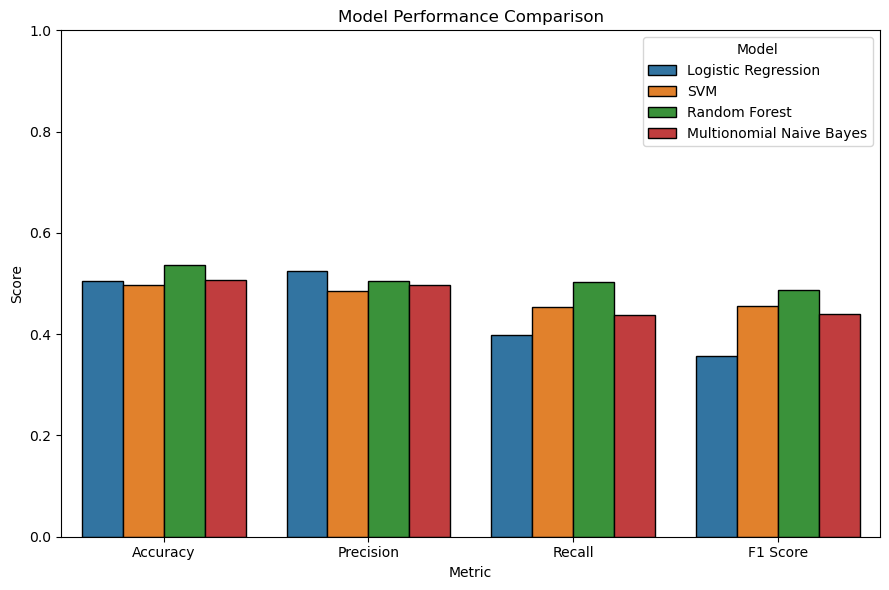

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

metrics = []

for name, model in best_models.items():
    y_pred_class = model.predict(X_test)
    metrics.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test_class, y_pred_class),
        "Precision": precision_score(y_test_class, y_pred_class, average="macro"),
        "Recall": recall_score(y_test_class, y_pred_class, average="macro"),
        "F1 Score": f1_score(y_test_class, y_pred_class, average="macro"),
    })

df_metrics = pd.DataFrame(metrics)

df_melted = df_metrics.melt(
    id_vars="Model",
    var_name="Metric",
    value_name="Score"
)

plt.figure(figsize=(9, 6))
sns.barplot(data=df_melted, x="Metric", y="Score", hue="Model", edgecolor='black')
plt.title("Model Performance Comparison")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

### ROC Curves:

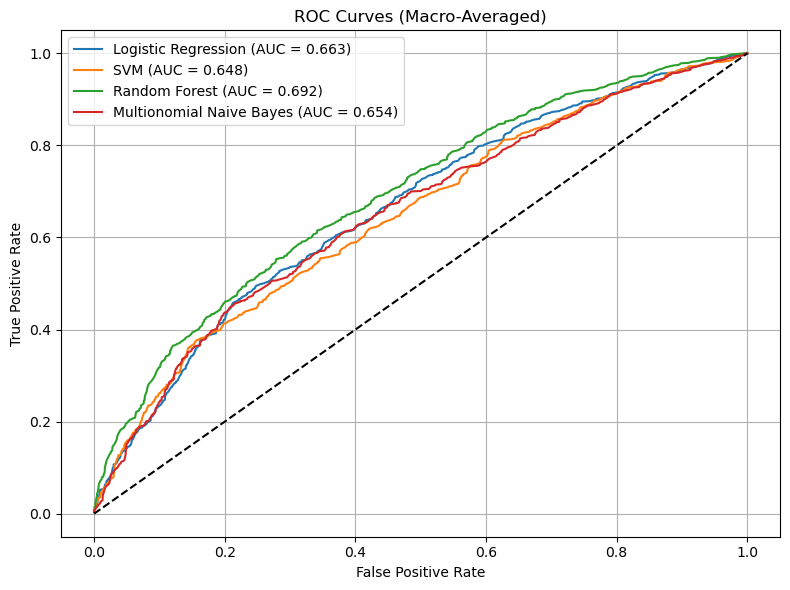

In [24]:
def get_model_scores(model, X):
    """
    Returns score matrix for ROC / PR curves.
    Uses predict_proba if available, else decision_function.
    """
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)
    elif hasattr(model, "decision_function"):
        scores = model.decision_function(X)
        if scores.ndim == 1:
            scores = scores.reshape(-1, 1)
        return scores
    else:
        raise ValueError("Model does not support probability or decision scores.")


from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

classes = np.unique(y_test_class)
y_test_bin = label_binarize(y_test_class, classes=classes)
n_classes = len(classes)

plt.figure(figsize=(8, 6))

for name, model in best_models.items():
    y_score = get_model_scores(model, X_test)

    fpr = []
    tpr = []

    for i in range(n_classes):
        f, t, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        fpr.append(f)
        tpr.append(t)

    all_fpr = np.unique(np.concatenate(fpr))
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes
    roc_auc = auc(all_fpr, mean_tpr)

    plt.plot(all_fpr, mean_tpr, label=f"{name} (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Macro-Averaged)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Precision-Recall Curves:

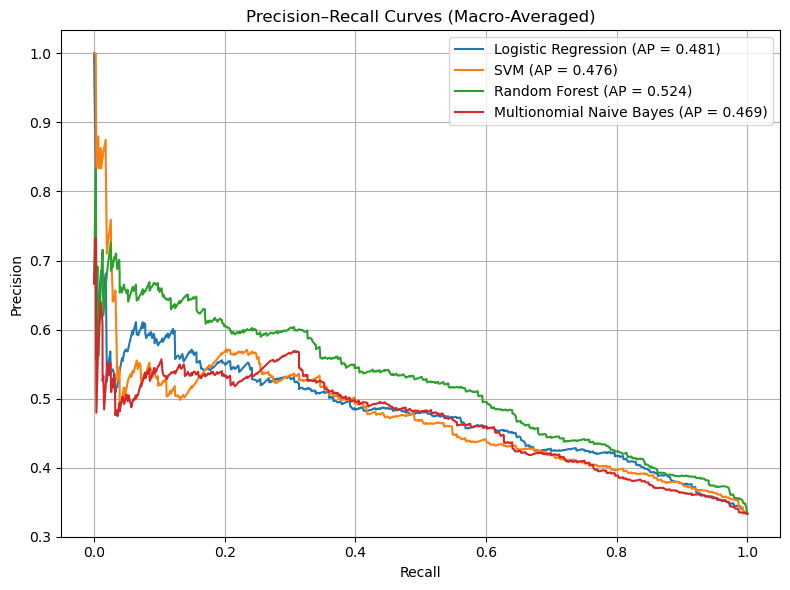

In [25]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(8, 6))

for name, model in best_models.items():
    y_score = get_model_scores(model, X_test)

    precision = []
    recall = []

    for i in range(n_classes):
        p, r, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
        precision.append(p)
        recall.append(r)

    all_recall = np.unique(np.concatenate(recall))
    mean_precision = np.zeros_like(all_recall)

    for i in range(n_classes):
        mean_precision += np.interp(all_recall, recall[i][::-1], precision[i][::-1])

    mean_precision /= n_classes
    ap = average_precision_score(y_test_bin, y_score, average="macro")

    plt.plot(all_recall, mean_precision, label=f"{name} (AP = {ap:.3f})") #Average Precision

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves (Macro-Averaged)")
plt.legend()
plt.grid(True)
plt.grid(True)
plt.tight_layout()
plt.show()

### Confusion Matrices:

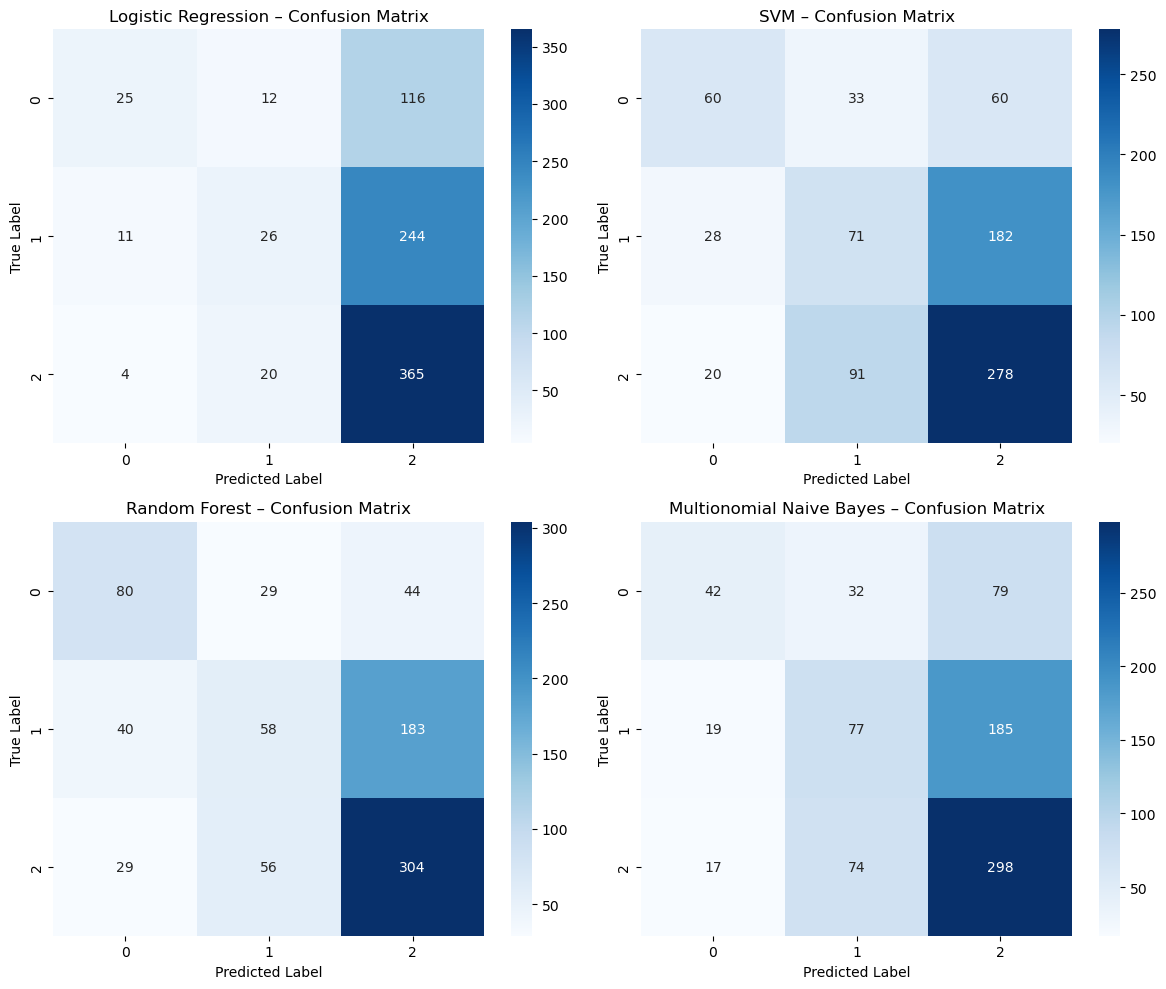

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for ax, (name, model) in zip(axes, best_models.items()):
    y_pred_class = model.predict(X_test)
    cm = confusion_matrix(y_test_class, y_pred_class)

    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        ax=ax
    )
    ax.set_title(f"{name} – Confusion Matrix")
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")

plt.tight_layout()
plt.show()

# ✅ Step 9: Save Best Classification Model

In [29]:
import joblib
best_class_model = best_models[results_df.iloc[0]["Model"]]
joblib.dump(best_class_model, "best_classification_model.pkl")
print("\nBest Classification Model saved successfully!!!\n\n\n")
best_class_model


Best Classification Model saved successfully!!!





,steps,"[('preprocess', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('tfidf', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


# 🤖 Step 10: Model Training for Regression alongwith Hyperparameter Tuning

In [30]:
y_score = df['problem_score']
X_train, X_test, y_train_score, y_test_score = train_test_split(X, y_score, test_size=0.2, random_state=42)

## Linear Regression:

In [31]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

pipe_lr = Pipeline([
    ("preprocess", preprocessor),
    ("reg", LinearRegression())
])

param_grid_lr = {
    # No hyperparameters to tune
}

gs_lr = GridSearchCV(
    pipe_lr,
    param_grid_lr,
    scoring="neg_mean_absolute_error",
    cv=5,
    n_jobs=-1
)

gs_lr.fit(X_train, y_train_score)

y_pred = gs_lr.predict(X_test)
mae = mean_absolute_error(y_test_score, y_pred)
rmse = root_mean_squared_error(y_test_score, y_pred)

print("Best Linear Regression Params:", gs_lr.best_params_)
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")

Best Linear Regression Params: {}
MAE  : 2.3675
RMSE : 2.9649


## Ridge Regression:

In [32]:
pipe_ridge = Pipeline([
    ("preprocess", preprocessor),
    ("reg", Ridge())
])

param_grid_ridge = {
    "reg__alpha": [0.1, 1.0, 10.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0]
}

gs_ridge = GridSearchCV(
    pipe_ridge,
    param_grid_ridge,
    scoring="neg_mean_absolute_error",
    cv=5,
    n_jobs=-1
)

gs_ridge.fit(X_train, y_train_score)

y_pred = gs_ridge.predict(X_test)
mae = mean_absolute_error(y_test_score, y_pred)
rmse = root_mean_squared_error(y_test_score, y_pred)

print("Best Ridge Regression Params:", gs_ridge.best_params_)
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")

Best Ridge Regression Params: {'reg__alpha': 10.0}
MAE  : 1.7118
RMSE : 2.0443


## Lasso Regression:

In [33]:
pipe_lasso = Pipeline([
    ("preprocess", preprocessor),
    ("reg", Lasso(max_iter=5000))
])

param_grid_lasso = {
    "reg__alpha": [0.001, 0.01, 0.1, 1.0]
}

gs_lasso = GridSearchCV(
    pipe_lasso,
    param_grid_lasso,
    scoring="neg_mean_absolute_error",
    cv=5,
    n_jobs=-1
)

gs_lasso.fit(X_train, y_train_score)

y_pred = gs_lasso.predict(X_test)
mae = mean_absolute_error(y_test_score, y_pred)
rmse = root_mean_squared_error(y_test_score, y_pred)

print("Best Lasso Regression Params:", gs_lasso.best_params_)
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")

Best Lasso Regression Params: {'reg__alpha': 0.001}
MAE  : 1.6975
RMSE : 2.0472


## Random Forest Regressor:

In [34]:
from sklearn.ensemble import RandomForestRegressor

pipe_rf = Pipeline([
    ("preprocess", preprocessor),
    ("reg", RandomForestRegressor(random_state=42))
])

param_grid_rf = {
    "reg__n_estimators": [300, 600],
    "reg__max_depth": [None, 20, 40],
    "reg__max_features": ["sqrt", "log2"],
    "reg__min_samples_split": [2, 5],
    "reg__min_samples_leaf": [1, 3],
}

gs_rf = GridSearchCV(
    pipe_rf,
    param_grid_rf,
    scoring="neg_mean_absolute_error",
    cv=5,
    n_jobs=-1
)

gs_rf.fit(X_train, y_train_score)

y_pred = gs_rf.predict(X_test)

mae = mean_absolute_error(y_test_score, y_pred)
rmse = root_mean_squared_error(y_test_score, y_pred)

print("Best Random Forest Regressor Params:", gs_rf.best_params_)
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")

Best Random Forest Regressor Params: {'reg__max_depth': None, 'reg__max_features': 'sqrt', 'reg__min_samples_leaf': 1, 'reg__min_samples_split': 2, 'reg__n_estimators': 600}
MAE  : 1.7146
RMSE : 2.0364


## Gradient Boosting Regressor:

In [35]:
pipe_gb = Pipeline([
    ("preprocess", preprocessor),
    ("reg", GradientBoostingRegressor(random_state=42))
])

param_grid_gb = {
    "reg__n_estimators": [300, 600],
    "reg__learning_rate": [0.05, 0.1],
    "reg__max_depth": [3, 5],
    "reg__subsample": [0.8, 1.0]
}

gs_gb = GridSearchCV(
    pipe_gb,
    param_grid_gb,
    scoring="neg_mean_absolute_error",
    cv=5,
    n_jobs=-1
)

gs_gb.fit(X_train, y_train_score)

y_pred = gs_gb.predict(X_test)
mae = mean_absolute_error(y_test_score, y_pred)
rmse = root_mean_squared_error(y_test_score, y_pred)

print("Best Gradient Boosting Regressor Params:", gs_gb.best_params_)
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")

Best Gradient Boosting Regressor Params: {'reg__learning_rate': 0.05, 'reg__max_depth': 5, 'reg__n_estimators': 300, 'reg__subsample': 0.8}
MAE  : 1.7076
RMSE : 2.0476


# 📈 Step 11: Model Evaluation and Comparison

### Model's MAE and RMSE Comparison:

In [36]:
best_models = {
    "Linear Regression": gs_lr.best_estimator_,
    "Lasso Regression": gs_lasso.best_estimator_,
    "Ridge Regression": gs_ridge.best_estimator_,
    "Random Forest": gs_rf.best_estimator_,
    "Gradient Boosting": gs_gb.best_estimator_
}

results = []

for name, model in best_models.items():
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test_score, y_pred)
    rmse = root_mean_squared_error(y_test_score, y_pred)
    results.append({
        "Model": name,
        "MAE": mae,
        "RMSE": rmse
    })

results_df = pd.DataFrame(results).sort_values(by="RMSE")
print(results_df.to_string(index=False))

            Model      MAE     RMSE
    Random Forest 1.714583 2.036429
 Ridge Regression 1.711827 2.044253
 Lasso Regression 1.697490 2.047180
Gradient Boosting 1.707647 2.047556
Linear Regression 2.367514 2.964912


### Model's MAE and RMSE Comparison Bar Chart:

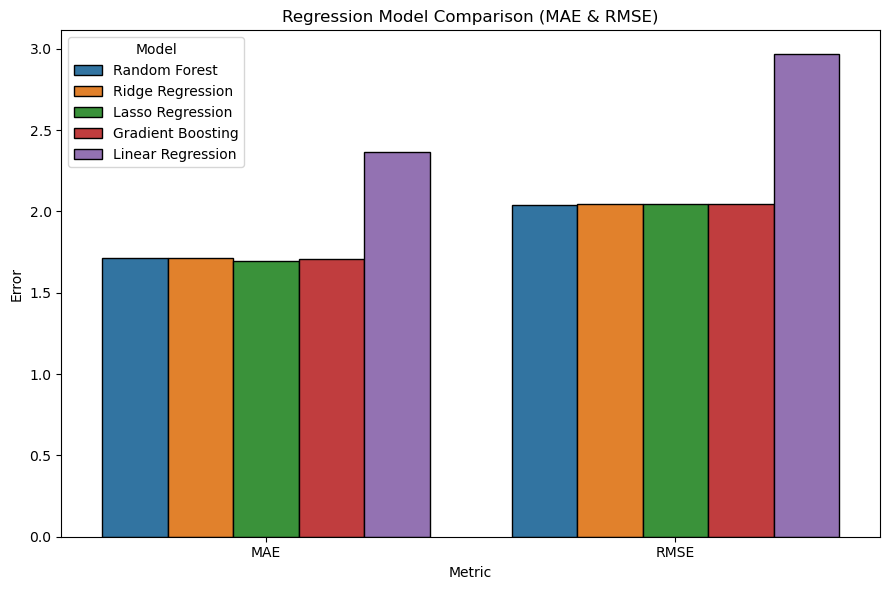

In [37]:
# Convert to long format for plotting
df_melted = results_df.melt(
    id_vars="Model",
    value_vars=["MAE", "RMSE"],
    var_name="Metric",
    value_name="Score"
)

plt.figure(figsize=(9, 6))
sns.barplot(
    data=df_melted,
    x="Metric",
    y="Score",
    hue="Model",
    edgecolor='black'
)
plt.title("Regression Model Comparison (MAE & RMSE)")
plt.ylabel("Error")
plt.xlabel("Metric")
plt.tight_layout()
plt.show()

### Actual vs Predicted:

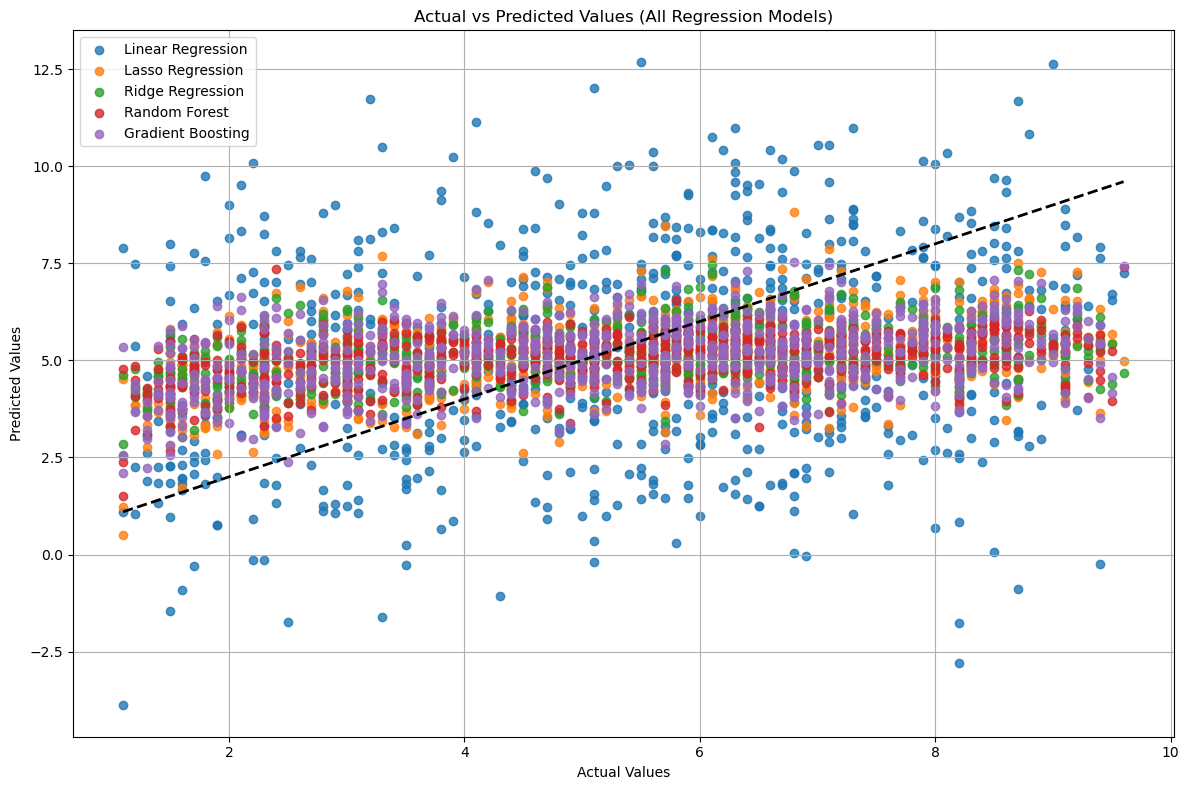

In [38]:
plt.figure(figsize=(12, 8))

for name, model in best_models.items():
    y_pred = model.predict(X_test)
    plt.scatter(
        y_test_score,
        y_pred,
        alpha=0.8,
        label=name
    )

# Ideal prediction line
min_val = min(y_test_score.min(), y_pred.min())
max_val = max(y_test_score.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], "k--", linewidth=2)

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values (All Regression Models)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Residual Distribution:

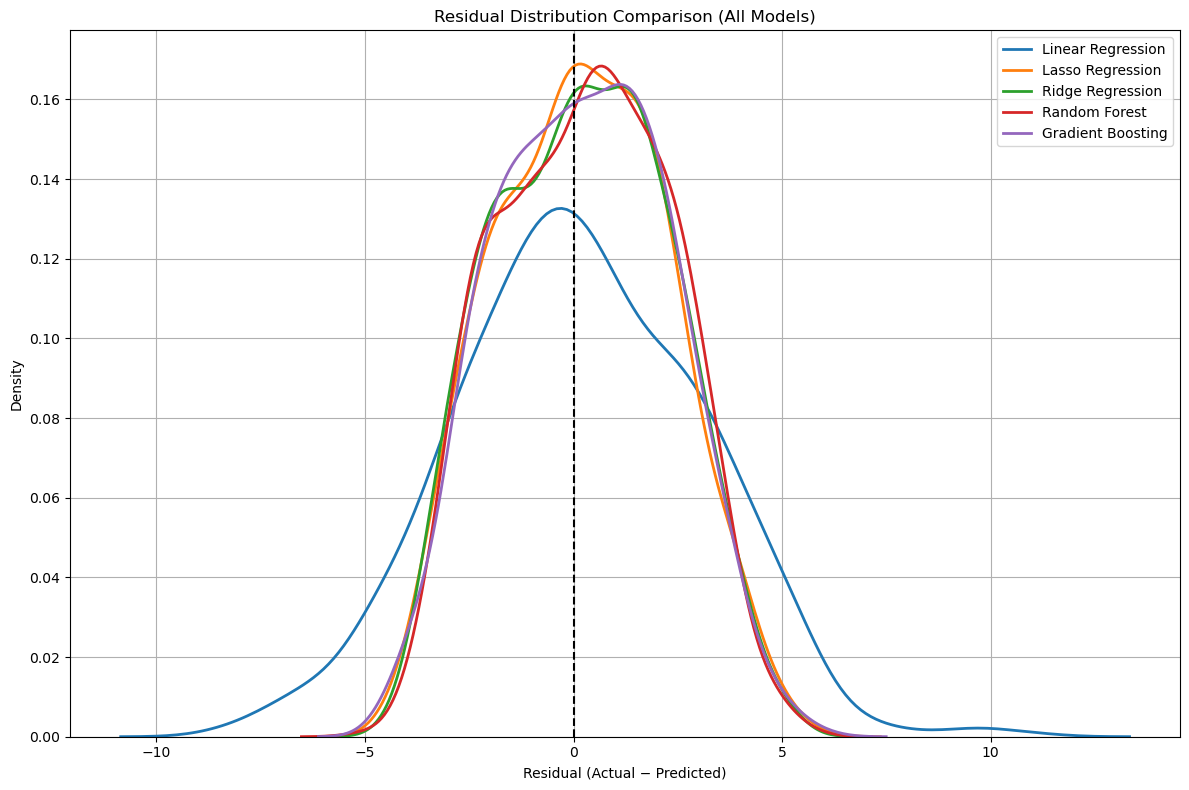

In [39]:
plt.figure(figsize=(12, 8))

for name, model in best_models.items():
    y_pred = model.predict(X_test)
    residuals = y_test_score - y_pred

    sns.kdeplot(
        residuals,
        label=name,
        linewidth=2
    )

plt.axvline(0, color="black", linestyle="--")
plt.xlabel("Residual (Actual − Predicted)")
plt.ylabel("Density")
plt.title("Residual Distribution Comparison (All Models)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Features Importances for Tree-based Models:

In [40]:
# Get feature names from preprocessor
tfidf_features = best_models["Random Forest"] \
    .named_steps["preprocess"] \
    .named_transformers_["tfidf"] \
    .get_feature_names_out()

numeric_features = best_models["Random Forest"] \
    .named_steps["preprocess"] \
    .transformers_[1][2]

feature_names = list(tfidf_features) + list(numeric_features)

### Random Forest Feature Importance

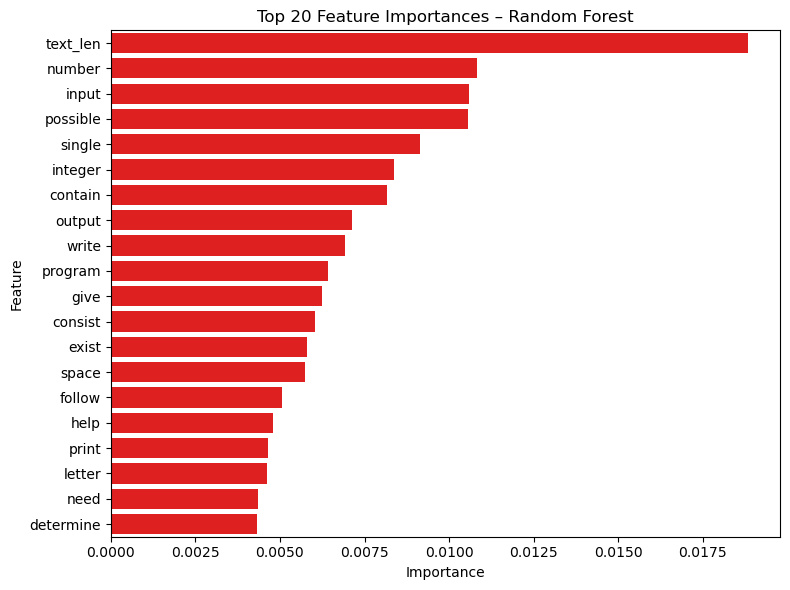

In [41]:
rf_model = best_models["Random Forest"].named_steps["reg"]
rf_importances = rf_model.feature_importances_

rf_df = (
    pd.DataFrame({
        "Feature": feature_names,
        "Importance": rf_importances
    })
    .sort_values(by="Importance", ascending=False)
    .head(20)
)

plt.figure(figsize=(8, 6))
sns.barplot(
    data=rf_df,
    x="Importance",
    y="Feature",
    color='red'
)
plt.title("Top 20 Feature Importances – Random Forest")
plt.tight_layout()
plt.show()

### Gradient Boosting Feature Importance

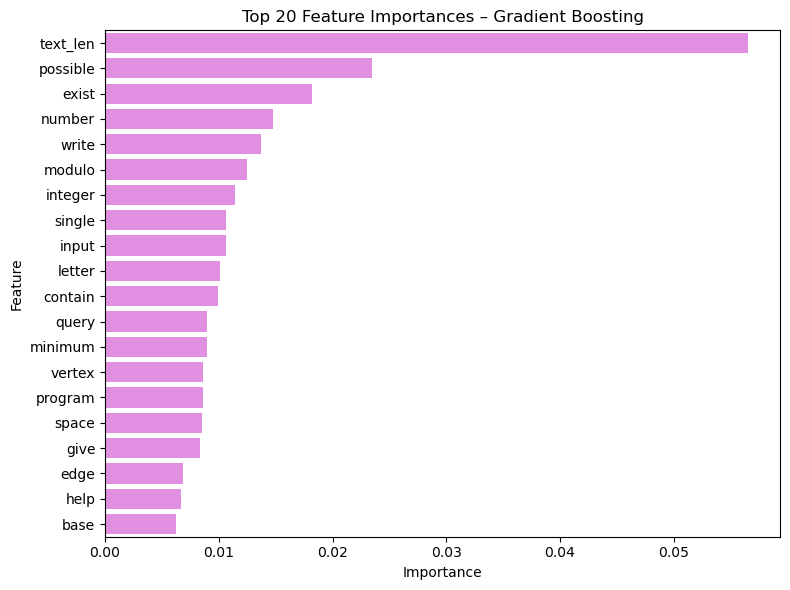

In [42]:
gb_model = best_models["Gradient Boosting"].named_steps["reg"]
gb_importances = gb_model.feature_importances_

gb_df = (
    pd.DataFrame({
        "Feature": feature_names,
        "Importance": gb_importances
    })
    .sort_values(by="Importance", ascending=False)
    .head(20)
)

plt.figure(figsize=(8, 6))
sns.barplot(
    data=gb_df,
    x="Importance",
    y="Feature",
    color='violet'
    
)
plt.title("Top 20 Feature Importances – Gradient Boosting")
plt.tight_layout()
plt.show()

# ✅ Step 12: Save Best Regression Model

In [43]:
best_reg_model = best_models[results_df.iloc[0]["Model"]]
joblib.dump(best_reg_model, "best_regression_model.pkl")
print("\nBest Regression Model saved successfully!!!\n")
best_reg_model


Best Regression Model saved successfully!!!



,steps,"[('preprocess', ...), ('reg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('tfidf', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
